# Building the pipeline for working with EEG data

In this notebook
- we build the codes to extract initial raw data;
- we calculate different metrics as measures of functional connectivity;
- based on calculated measures like Mutual Information and Coherence we create Adjacency Matrices; 
- we create graphs based on the previously calculated metrics;
- make some plots to visualize the obtained graphs.

MAYBE based on graphs we will train some graph convolutional neural networks...

# 0 - Required packages



In [1]:
import sys
from glob2 import glob

import numpy as np
import pandas as pd # dataframes, tables 
import seaborn as sns # plotting
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

import networkx as nx

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

# 1 - Datasets Links

 Links for downloading the datasets: https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml
 
 Command for getting the data from the server: 
- rsync -auxvL nedc@www.isip.piconepress.com:data/eeg/tuh_eeg_abnormal/v2.0.0/ . 
- rsync -auxvL nedc@www.isip.piconepress.com:data/eeg/tuh_eeg_epilepsy/v1.0.0/ .

TUH EEG Epilepsy Corpus. It was created to provide data for the purposes of automatic analysis of EEG. The patients were sorted by using a filter that categorized patients into two classes: epilepsy and not epilepsy. This was based on information in the session reports relating to their clinical history, medications at the time of recording, and EEG features associated with epilepsy. 
This subset contains European data format (EDF) files and corresponding neurologist reports for 1,648 files in  561 sessions from 200 patients. From these, 1473 files in 436 sessions from 100 patients have epilepsy, whereas 326 files in 134 sessions from 100 patients do not have epilepsy.
link: https://isip.piconepress.com/conferences/ieee_spmb/2017/papers/p01_13.pdf

FILENAME STRUCTURE "TUH EEG Epilepsy Corpus.":

 A typical filename in this corpus is: edf/epilepsy/01_tcp_ar/003/00000355/s003_2013_01_04/00000355_s003_t000.edf

 The first segment, "edf/", is a directory name for the directory containing the data, which consists of edf files (*.edf) and EEG reports (*.txt).

 The second segment denotes either patients with epilepsy ("/epilepsy") or patients with without epilepsy ("/no_epilepsy").

 The third segment ("/01_tcp_ar") denotes the type of channel configuration for the EEG. "/01_tcp_ar" refers to an AR reference configuration.

 The fourth segment ("003") is a three-digit identifier meant to keep the number of subdirectories in a directory manageable. This follows the TUH EEG v1.1.0 convention.

 The fifth segment ("/00000355") denotes an anonymized patient ID. The IDs are consistent across all of our databases involving Temple
 Hospital EEG data.

 The sixth segment ("/s003_2013_01_04") denotes the session number("s003"), and the date the EEG was archived at the hospital("01/04/2013").

 The seventh, or last, segment is the filename ("00000355_s003_t000.edf"). This includes the patient number, the session number and a token number ("t000").

 Sessions were sorted into epilepsy and no epilepsy categories by searching the associated EEG reports for indications as to a epilepsy/no epilepsy 
 diagnosis based on clinical history, medications at the time of recording, and EEG features associated with epilepsy such as spike and sharp waves. 


## 1.1 - Loading data from .edf files

In [2]:
# reading the list of file names in the EEG Epilepsy Corpus
edf_file_list = glob("../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf")


#edf_file_list = glob("../tuh_eeg_abnormal/edf/*/*/*/*/*/*/*.edf")
len(edf_file_list)

1648

There are 1648 with data files in the TUH Epilepsy database.

In [3]:
# print out several filenames
edf_file_list[:4]

['../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t001.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t003.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t002.edf']

In [4]:
# extract subject IDs from the file path, create python set to extract unique elements from list, convert to list again 
unique_epilepsy_patient_ids = list(set([x.split("/")[-1].split("_")[0] for x in edf_file_list]))
len(unique_epilepsy_patient_ids)

200

There are 200 unique patients in the database.

In [5]:
# write down the list all the patient IDs into one file for later use
# with open('./epilepsy_corpus_subjects.txt', 'w') as file_handler:
    # for item in unique_epilepsy_patient_ids:
    #     file_handler.write("{}\n".format(item))

In [6]:
edf_file_list[0].split("/")

['..',
 'tuh_eeg_epilepsy',
 'edf',
 'epilepsy',
 '03_tcp_ar_a',
 '076',
 '00007656',
 's010_2011_03_13',
 '00007656_s010_t000.edf']

In [7]:
def read_edf_to_pandas(edf_filename, select_channels = True):
    """ Reads data from an edf file to a Pandas dataframe.
        Column names are 'channel_labels'.
        
        If 'select_channels=True', then only 19 common channels are selected to 
        create the resulting dataframe. The channel names will be updated (standardized).
        
        Returns: dataframe, channel labels
    """
    # read edf file
    raw_data = read_raw_edf(edf_filename, verbose=False, preload=False)
    
    if select_channels:
        # the TUEP database has 3 EEG channel configurations: '02_tcp_le', '03_tcp_ar_a', '01_tcp_ar'
        # number of channels and channel names differ within these configurations
        # to be able to compare the different EEG readings we need to select channels
        # that are common for all configurations

        # the list of 19 channels (their short labels) that we will use for analysing EEG data
        channels_to_use = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8',
                           'T3', 'C3', 'CZ', 'C4', 'T4', 'T5',
                           'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']
        
        # the function to update channel names from original to new format:
        ch_name_update_func = lambda ch: ch.split(' ')[-1].split('-')[0]

        # renaming the original channel names in one .edf file;
        # the update will be written into the in-memory edf object
        raw_data.rename_channels(mapping=ch_name_update_func)
        
        # check if all required channels are in the edf file
        try:
            assert all([ch in raw_data.info["ch_names"] for ch in channels_to_use])
        except:
            print('Not all required channels are in the edf file.')
        
        # dataframe with EEG readings from selected channels and with 
        # updated channel names
        df = pd.DataFrame(raw_data.pick_channels(channels_to_use).get_data().T,
            columns=raw_data.pick_channels(channels_to_use).info['ch_names'])
        
        # we need to return correct channel/column names
        channel_labels = channels_to_use # as specified by us: left-to-right and top-down
        # channel_labels = df.columns.tolist() # as given in the edf file
        
    else:
        # get channel names from edf file
        channel_labels = raw_data.info["ch_names"]

        # create a dataframe from
        df = pd.DataFrame(raw_data.get_data().T, columns=channel_labels)

    return df[channel_labels], channel_labels # as specified by us: left-to-right and top-down
    # return df, channel_labels # as given in the edf file

# !!! NEED TO DECIDE !!!
# what order of channels should be given in the dataframe?
#      - as specified in the edf file
#      - as chosen by us: left-to-right and top-down

In [9]:
edf_file_epilepsy = '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf'
edf_file_no_epilepsy = '../tuh_eeg_epilepsy/edf/no_epilepsy/03_tcp_ar_a/076/00007671/s002_2011_02_03/00007671_s002_t002.edf'
signle_edf_name = (edf_file_no_epilepsy, edf_file_epilepsy)

In [10]:
raw_data_epilepsy = read_raw_edf(edf_file_epilepsy,
                       verbose=0, preload=False)

raw_data_no_epilepsy = read_raw_edf(edf_file_no_epilepsy,
                       verbose=0, preload=False)

single_edf_file = (raw_data_no_epilepsy, raw_data_epilepsy)

In [11]:
df_, ch_ = read_edf_to_pandas(edf_file_epilepsy)

In [13]:
df_.head()

,FP1,FP2,F7,F3,FZ,F4,F8,T3,C3,CZ,C4,T4,T5,P3,PZ,P4,T6,O1,O2
0,-0.000055,-0.000034,-0.000066,-0.000044,-0.000035,-0.000037,-0.000025,-0.000061,-0.000019,-0.000011,-0.000018,-0.000022,-0.000046,-0.000023,-0.000015,-0.000013,-0.000017,-0.000019,-3.306223e-07
1,-0.000053,-0.000024,-0.000067,-0.000055,-0.000026,-0.000031,-0.000014,-0.000055,-0.000013,-0.000005,-0.000012,-0.000012,-0.000046,-0.000016,-0.000011,-0.000011,-0.000009,-0.000035,7.365690e-06
2,-0.000057,-0.000037,-0.000072,-0.000054,-0.000037,-0.000039,-0.000029,-0.000068,-0.000025,-0.000013,-0.000020,-0.000027,-0.000051,-0.000028,-0.000019,-0.000019,-0.000021,-0.000030,-6.521134e-06
3,-0.000062,-0.000049,-0.000074,-0.000044,-0.000048,-0.000045,-0.000041,-0.000078,-0.000035,-0.000021,-0.000026,-0.000038,-0.000054,-0.000038,-0.000026,-0.000022,-0.000031,-0.000016,-1.789829e-05
4,-0.000060,-0.000037,-0.000070,-0.000045,-0.000038,-0.000037,-0.000028,-0.000068,-0.000025,-0.000013,-0.000018,-0.000026,-0.000050,-0.000028,-0.000020,-0.000015,-0.000021,-0.000019,-7.023068e-06


## 1.3 - Function for computing and plotting the Correlation Matrix

In [49]:
def compute_corr_matrix(edf_filename):
    
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)
    
    # calculate the correlation matrix
    corr_matrix = df.corr()
    
    return corr_matrix


def plot_correlation_matrix(edf_filename):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a correlation matrix.
    """
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)
    
    # calculate the correlation matrix
    corr_matrix = df.corr()
        
    # plot the heatmap for correlation matrix
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.heatmap(corr_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Correlation Matrix')
    plt.xlabel('channel_names')
    plt.ylabel('channel_names')
     
    # return fig
    

### 1.3.1 - Plots (heatmaps) of correlation matrices

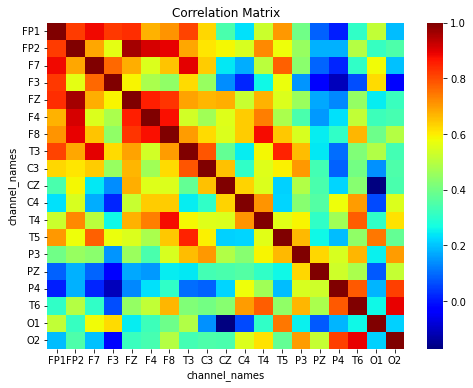

In [53]:
plot_correlation_matrix(edf_filename=edf_file_epilepsy)
plt.savefig('corr_mat_epilepsy.pdf', dpi=150, bbox_inches='tight')

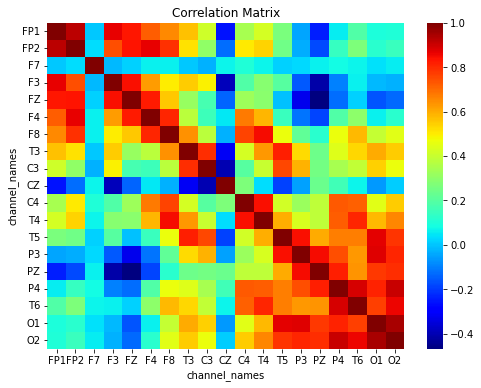

In [51]:
plot_correlation_matrix(edf_filename=edf_file_no_epilepsy)
plt.savefig('corr_mat_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

## 1.4 - Function for computing and plotting the Mutual Information Matrix

In [55]:
def entropy(bins, *X):
    
    # binning of the data
    data, *edges = np.histogramdd(X, bins=bins)
    
    # calculate probabilities
    data = data.astype(float)/data.sum()
    
    # compute H(X,Y,...,Z) = sum(-P(x,y,...,z) ∗ log2(P(x,y,...,z)))
    return np.sum(-data * np.log2(data+sys.float_info.epsilon))


def mutual_information(bins, X, Y):
    
    # compute I(X,Y) = H(X) + H(Y) − H(X,Y)
    
    H_X = entropy(bins, X)
    H_Y = entropy(bins, Y)
    H_XY = entropy(bins, X, Y)
    
    return H_X + H_Y - H_XY
# Compute number of bins using Sturge's rule

def compute_mi_matrix(bins, df, normalized=False):
    """ Compute Mutual Information matrix from dataframe with EEG data.
    
        Return: mi_matrix
    """
    n_cols = df.shape[1]
    mi_matrix = np.zeros([n_cols, n_cols])
    
    # # Sturge's rule for number of bins
    # n_bins = int(1 + 3.322*np.log2(df.shape[0]))
    
    for i in range(n_cols):
        for j in range(n_cols):
            # mi = mutual_information(n_bins, df.iloc[:,i],df.iloc[:,j])
            mi = mutual_information(bins, df.iloc[:,i],df.iloc[:,j])
            mi_matrix[i,j] = mi

    return mi_matrix


def compute_normed_mi_matrix(mi_matrix):
    """ Compute normalized version of the given Mutual Information matrix.
    
        Return: normed_mi_matrix
    """
    
    # normalize mi matrix by dividing matrix elements with
    # sqrt of product of respective diagonal elements
    divisor_matrix = np.sqrt(np.diag(mi_matrix)*np.diag(mi_matrix).reshape(-1,1))
    normed_mi_matrix = mi_matrix/divisor_matrix

    return normed_mi_matrix

In [56]:
def plot_mutual_information_matrix(edf_filename, bins = 20):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a mutual information matrix.
    """
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)

    # calculate the normalized mutual information matrix
    mi_matrix = compute_mi_matrix(bins, df)
           
    # plot the heatmap for mutual information matrix
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.heatmap(mi_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Mutual Information Matrix')
    plt.xlabel('channel_names')
    plt.ylabel('channel_names')


def plot_normed_mutual_information_matrix(edf_filename, bins = 20):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a normalized mutual information matrix.
    """
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)

    # calculate the normalized mutual information matrix
    mi_matrix = compute_mi_matrix(bins, df)
    normed_mi_matrix = compute_normed_mi_matrix(mi_matrix)

    # plot the heatmap for mutual information matrix
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.heatmap(normed_mi_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Normalized Mutual Information Matrix')
    plt.xlabel('channel_names')
    plt.ylabel('channel_names')

### 1.4.1 - Plots (heatmaps) of NOT normalized mutual information matrices

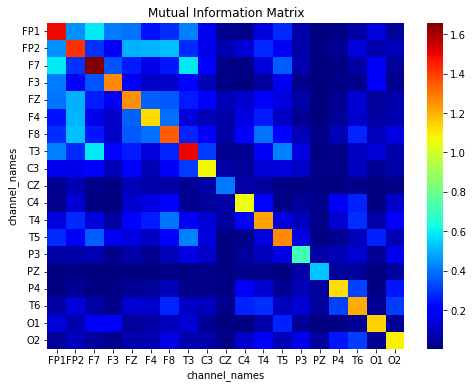

In [57]:
plot_mutual_information_matrix(edf_filename=edf_file_epilepsy, bins = 20)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
plt.savefig('mi_mat_epilepsy.pdf', dpi=150, bbox_inches='tight')

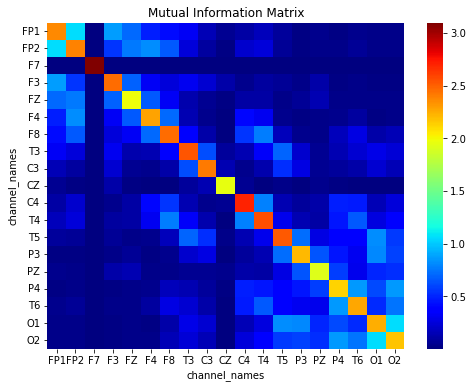

In [58]:
plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
plt.savefig('mi_mat_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.4.2 - Plots (heatmaps) of normalized mutual information matrices

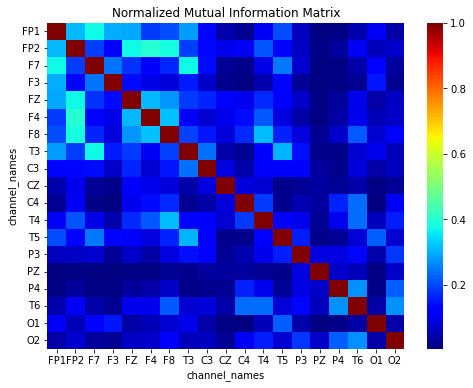

In [60]:
plot_normed_mutual_information_matrix(edf_filename=edf_file_epilepsy, bins = 20)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
plt.savefig('normed_mi_mat_epilepsy.pdf', dpi=150, bbox_inches='tight')

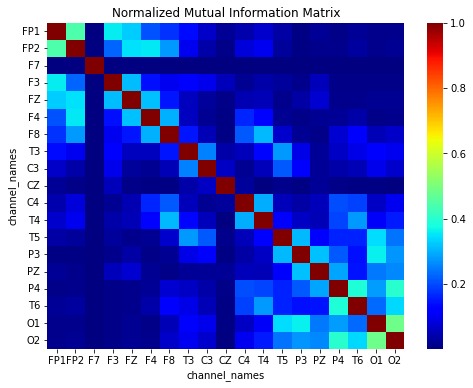

In [59]:
plot_normed_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
plt.savefig('normed_mi_mat_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

## 1.5 - Hierarchical clustering and Dendrogram

In [61]:
def plot_dendogram(matrix, channel_labels):

    fig, ax = plt.subplots(1,1, figsize=(10,7))
    
    linkage_data = linkage(matrix,
                           metric = "euclidean",
                           method = "ward")
    
    dendrogram_plt = dendrogram(linkage_data,
                                labels = channel_labels,
                                ax = ax
                               )
    
    plt.title('Dendrogram')
    plt.xlabel('channels')
    plt.ylabel('Euclidean distances')
    
    return dendrogram_plt, linkage_data

### 1.5.1 - Dendrograms and clustermaps for NOT normalized mutual information matrices

In [135]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)

# calculate the mutual information matrix
mi_matrix_epilepsy = compute_mi_matrix(bins=20, df=df)

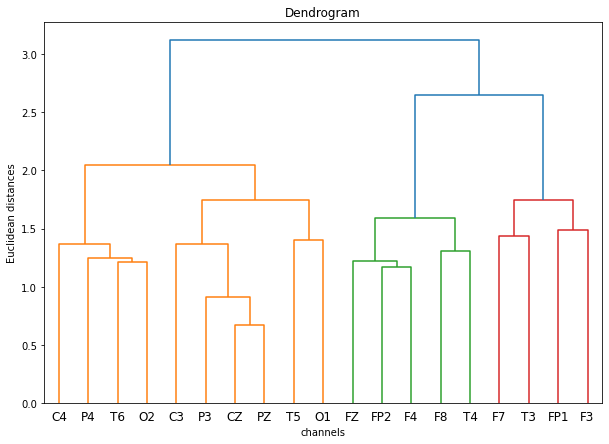

In [66]:
dendrogram_plt, linkage_data = plot_dendogram(mi_matrix_epilepsy, channel_labels)
plt.savefig('dendr_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

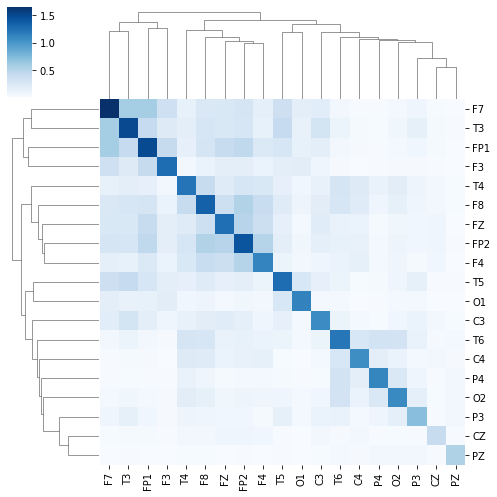

In [102]:
mi_df = pd.DataFrame(mi_matrix_epilepsy, columns=channel_labels, index=channel_labels)
sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
plt.savefig('clustermap_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

In [67]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)

# calculate the mutual information matrix
mi_matrix_no_epilepsy = compute_mi_matrix(bins=20, df=df)

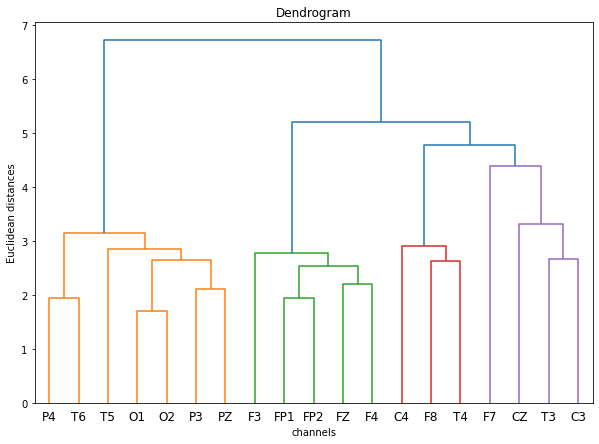

In [68]:
dendrogram_plt, linkage_data = plot_dendogram(mi_matrix_no_epilepsy, channel_labels)
plt.savefig('dendr_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

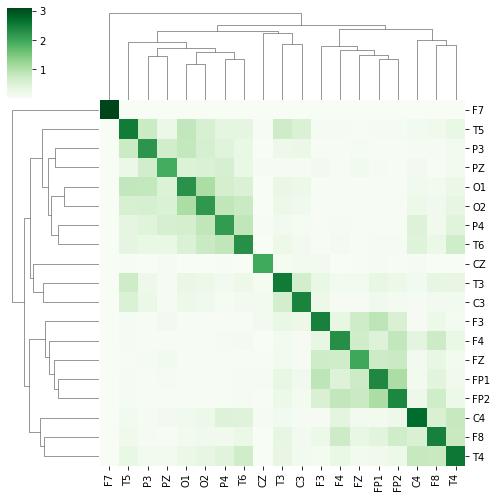

In [92]:
mi_df = pd.DataFrame(mi_matrix_no_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
plt.savefig('clustermap_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.5.2 - Dendrograms for normalized mutual information matrices

In [69]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)

# calculate the mutual information matrix
normed_mi_matrix_epilepsy = compute_normed_mi_matrix(mi_matrix_epilepsy)

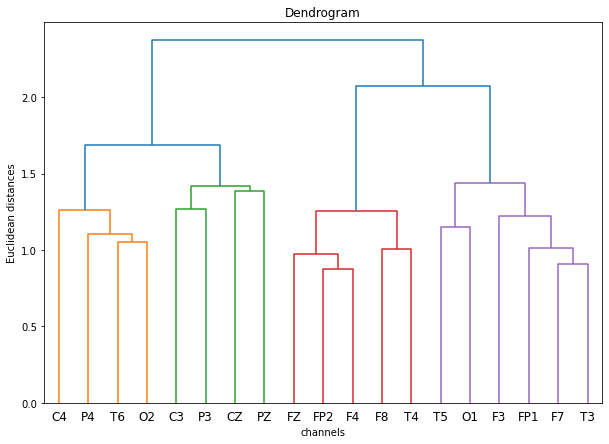

In [70]:
dendrogram_plt, linkage_data = plot_dendogram(normed_mi_matrix_epilepsy, channel_labels)
plt.savefig('dendr_normed_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

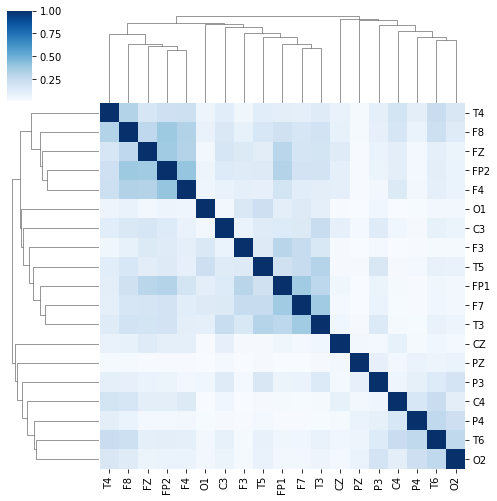

In [93]:
mi_df = pd.DataFrame(normed_mi_matrix_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
plt.savefig('clustermap_normed_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

In [71]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)

# calculate the mutual information matrix
normed_mi_matrix_no_epilepsy = compute_normed_mi_matrix(mi_matrix_no_epilepsy)

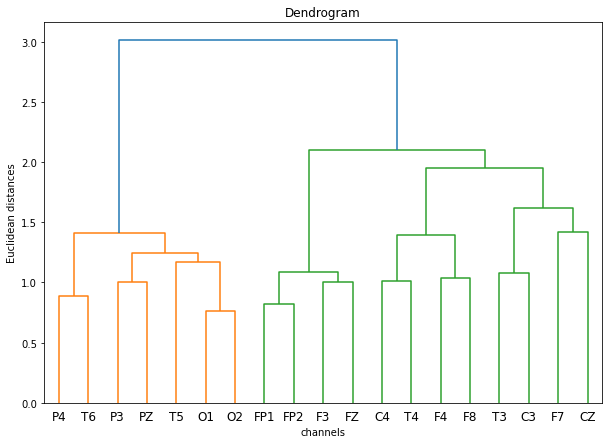

In [72]:
dendrogram_plt, linkage_data = plot_dendogram(normed_mi_matrix_no_epilepsy, channel_labels)
plt.savefig('dendr_normed_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

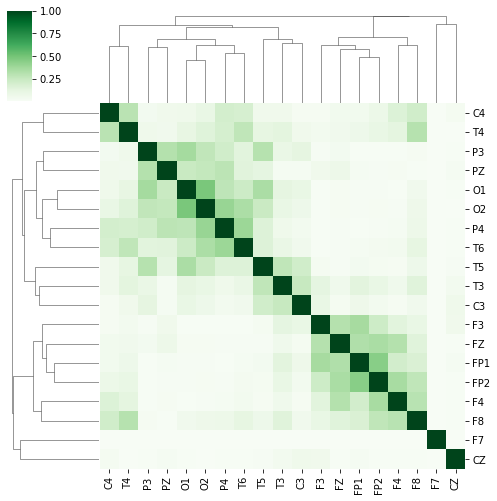

In [94]:
mi_df = pd.DataFrame(normed_mi_matrix_no_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
plt.savefig('clustermap_normed_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.5.3 - Dendrograms and clustermaps for correlation matrices

In [77]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)

# calculate the mutual information matrix
cor_matrix_epilepsy = compute_corr_matrix(edf_file_epilepsy)

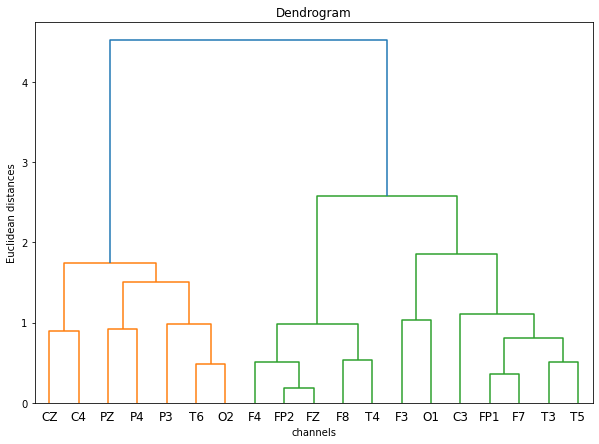

In [78]:
dendrogram_plt, linkage_data = plot_dendogram(cor_matrix_epilepsy, channel_labels)
plt.savefig('dendr_corr_epilepsy.pdf', dpi=150, bbox_inches='tight')

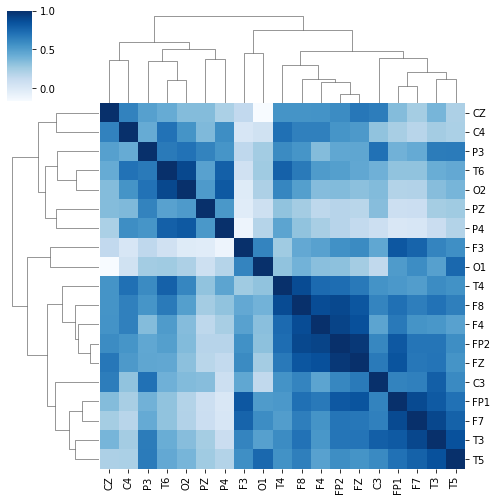

In [96]:
mi_df = pd.DataFrame(cor_matrix_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
plt.savefig('clustermap_corr_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

In [74]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)

# calculate the mutual information matrix
cor_matrix_no_epilepsy = compute_corr_matrix(edf_file_no_epilepsy)

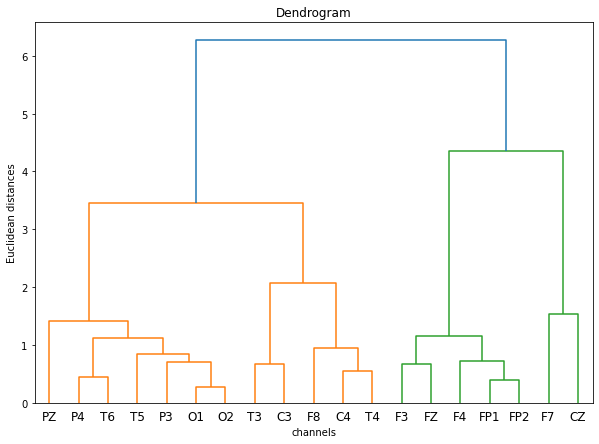

In [76]:
dendrogram_plt, linkage_data = plot_dendogram(cor_matrix_no_epilepsy, channel_labels)
plt.savefig('dendr_corr_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

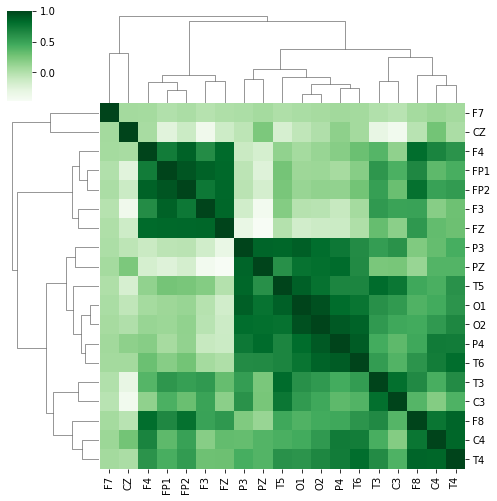

In [95]:
mi_df = pd.DataFrame(cor_matrix_no_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
plt.savefig('clustermap_corr_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

## 1.6 - Graph representations based on computed matrices

![10-20 system](https://static-01.hindawi.com/articles/js/volume-2020/3083910/figures/3083910.fig.001.svgz)
<img src="https://www.vhv.rs/dpng/d/522-5220413_64-channel-eeg-cap-hd-png-download.png" alt="drawing" width="400"/>

In [97]:
# the TUEP database has 3 EEG channel configurations: '02_tcp_le', '03_tcp_ar_a', '01_tcp_ar'
# number of channels and channel names differ within these configurations
# to be able to compare the different EEG readings we need to select channels
# that are common for all configurations

# the list of channels (their short labels) that we will use for analysing EEG data
# labels are written in the left-to-right and top-down order, as presented in the figure
channels_to_use = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']

# the process of deducing these channels and labels is described below

In [98]:
# electrode positions for the graph nodes
# based on the pictures above
node_positions = {'FP1': (-0.4, 0.45),
                  'FP2': (0.4, 0.45),
                  'F7': (-1.25, 0.33),
                  'F3': (-0.65, 0.255),
                  'FZ': (0.0, 0.225),
                  'F4': (0.65, 0.255),
                  'F8': (1.25, 0.33),
                  'T3': (-1.5, 0.0),
                  'C3': (-0.75, 0.0),
                  'CZ': (0.0, 0.0),
                  'C4': (0.75, 0.0),
                  'T4': (1.5, 0.0),
                  'T5': (-1.25, -0.33),
                  'P3': (-0.65, -0.255),
                  'PZ': (0.0, -0.225),
                  'P4': (0.65, -0.255),
                  'T6': (1.25, -0.33),
                  'O1': (-0.4, -0.45),
                  'O2': (0.4, -0.45)
                 }

nodelist = node_positions.keys()

In [188]:
edge_colors = plt.cm.Blues
node_colors = 'red'

def plot_graph(G, ax, add_edge_labels=False):
    plt.figure(figsize=(7,7))

    # plot nodes
    nx.draw_networkx_nodes(G,
                           node_positions,
                           nodelist=nodelist,
                           node_size=800, 
                           node_color=node_colors,
                           alpha=0.7,
                           ax=ax)

    # plot node labels
    nx.draw_networkx_labels(G,
                            node_positions,
                            labels=dict(zip(nodelist, nodelist)),
                            font_color='white',
                            font_size=14,
                            font_weight='bold',
                            ax=ax
                           )
    
    edge_weights = nx.get_edge_attributes(G,'weight')
    
    # plot edges
    plt_graph_obj = nx.draw_networkx_edges(
        G, node_positions,
        edge_cmap=edge_colors,
        width=5,
        edge_color=[G[u][v]['weight'] for u, v in G.edges],
        ax=ax
    )
    
    # plot edge labels (weights)
    if add_edge_labels:
        edge_labels = nx.draw_networkx_edge_labels(
            G, node_positions,
            edge_labels=edge_weights,
            label_pos=0.5,
            ax=ax
        )
    
    # plt.box(False)
    # ax.axis('off')
    
    return edge_weights

### 1.6.1 - Functional connectivity graphs and MST plots for NOT normalized mutual information matrices

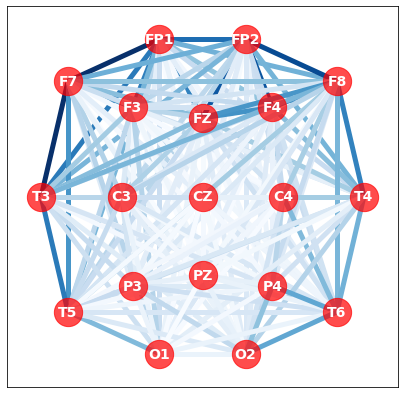

In [189]:
mi_df = pd.DataFrame(mi_matrix_epilepsy, columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']

# exclude 0-weight edges and self-edges 
graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                               (edge_list_df['from_node'] != edge_list_df['to_node'])
                                 ]
# create the graph
G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
edge_weights = plot_graph(G, ax=None, add_edge_labels=False)

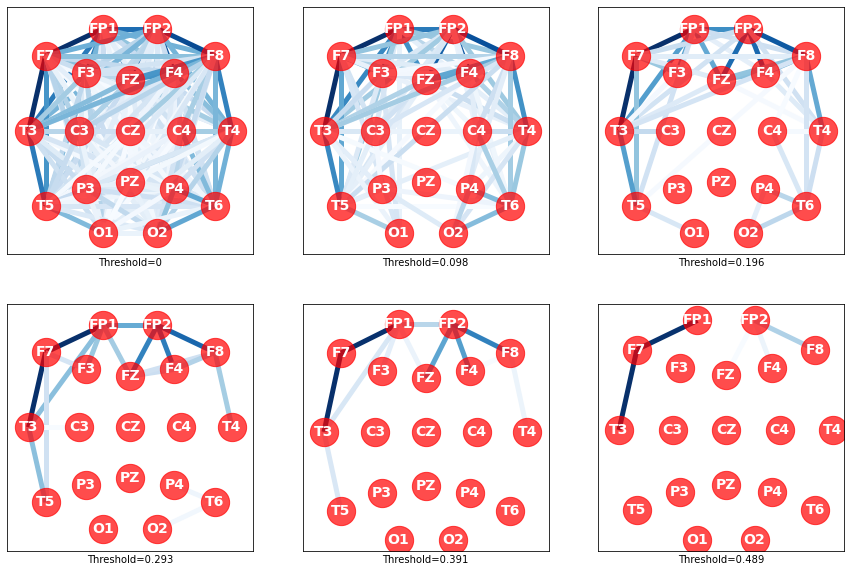

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [207]:
mi_df = pd.DataFrame(mi_matrix_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(mi_matrix_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

fig.savefig('fc_by_th_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

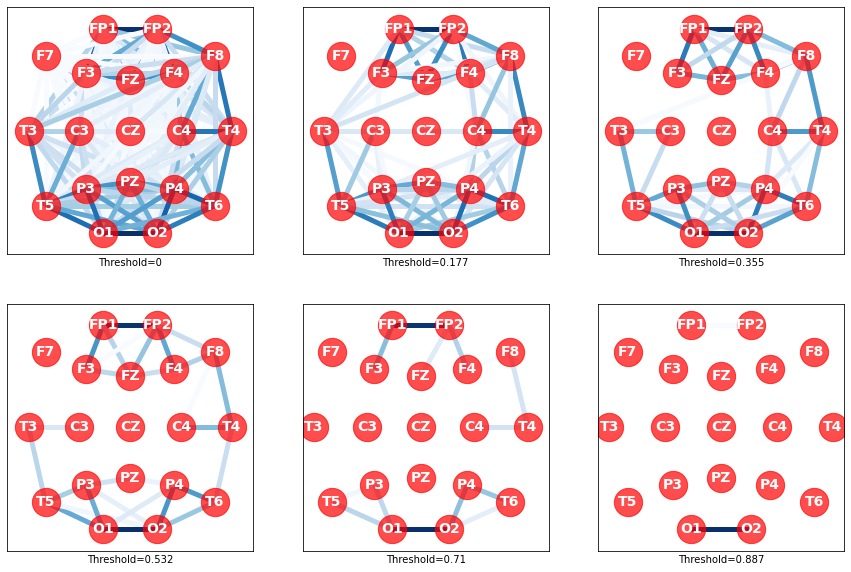

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [208]:
mi_df = pd.DataFrame(mi_matrix_no_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(mi_matrix_no_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

fig.savefig('fc_by_th_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.6.2 - Functional connectivity graphs and MST plots for normalized mutual information matrices

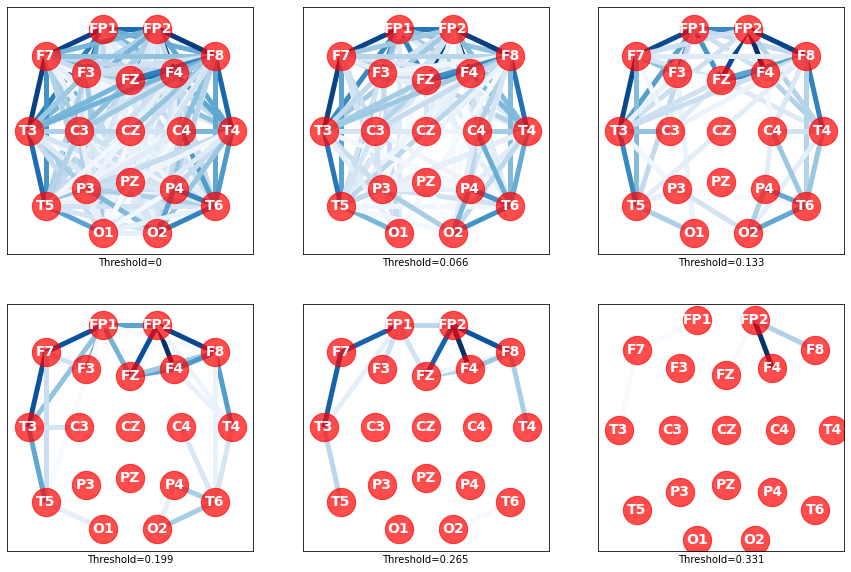

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [224]:
mi_df = pd.DataFrame(normed_mi_matrix_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(normed_mi_matrix_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

fig.savefig('fc_by_th_normed_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

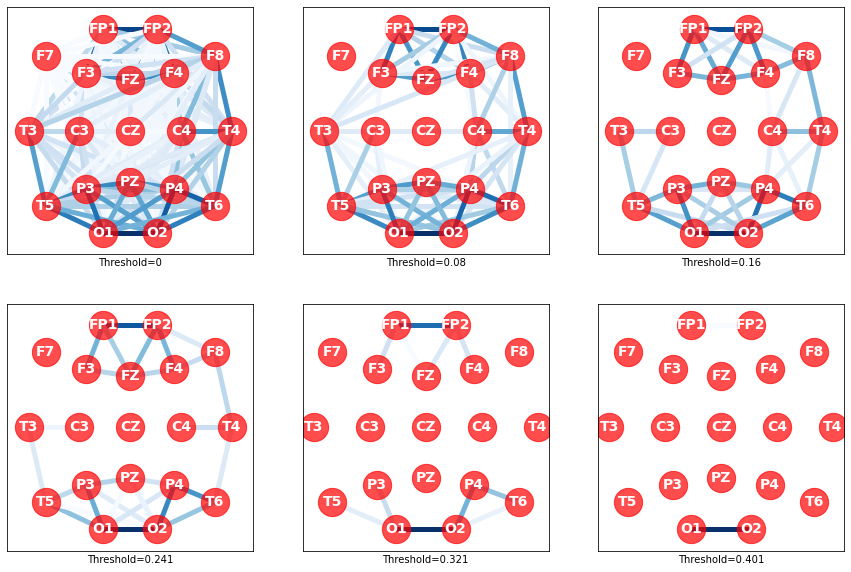

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [225]:
mi_df = pd.DataFrame(normed_mi_matrix_no_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(normed_mi_matrix_no_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

fig.savefig('fc_by_th_normed_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.6.3 - Functional connectivity graphs and MST plots for correlation matrix

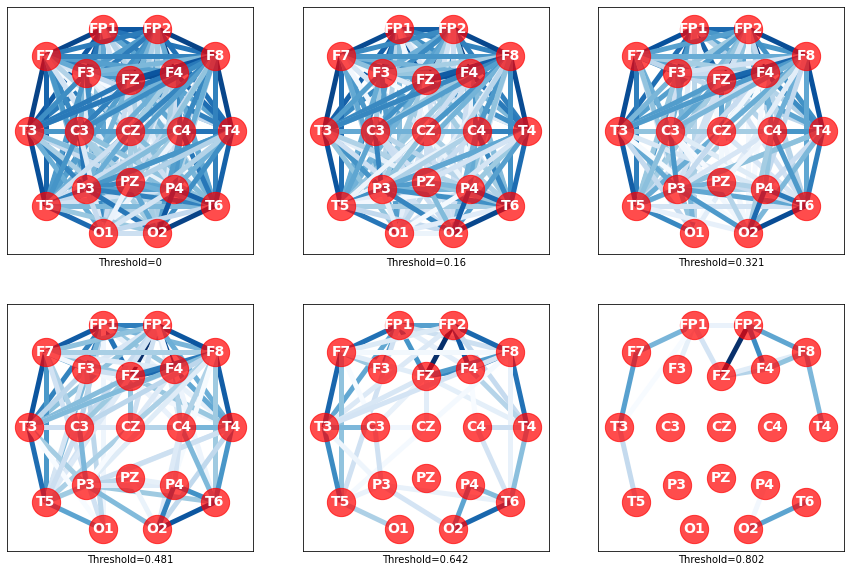

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [227]:
mi_df = pd.DataFrame(cor_matrix_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(cor_matrix_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

fig.savefig('fc_by_th_corr_epilepsy.pdf', dpi=150, bbox_inches='tight')

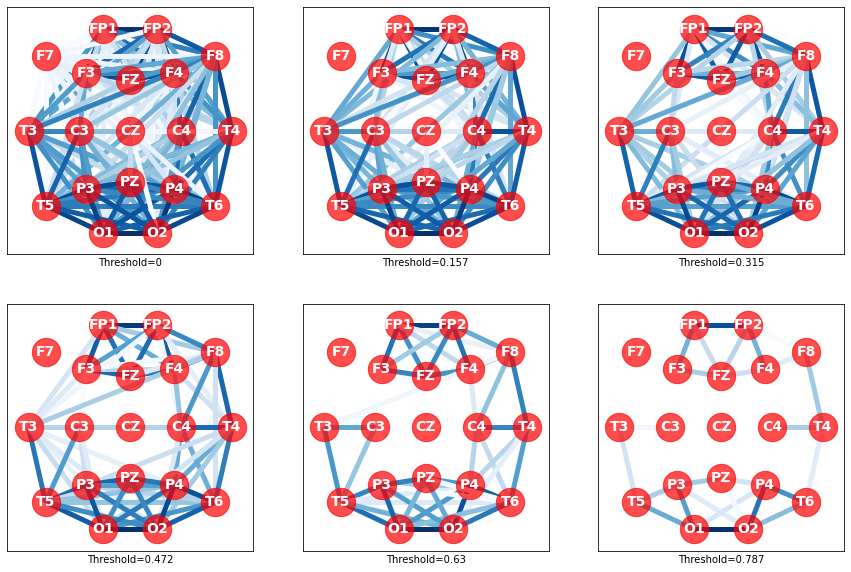

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [226]:
mi_df = pd.DataFrame(cor_matrix_no_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(cor_matrix_no_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

fig.savefig('fc_by_th_corr_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

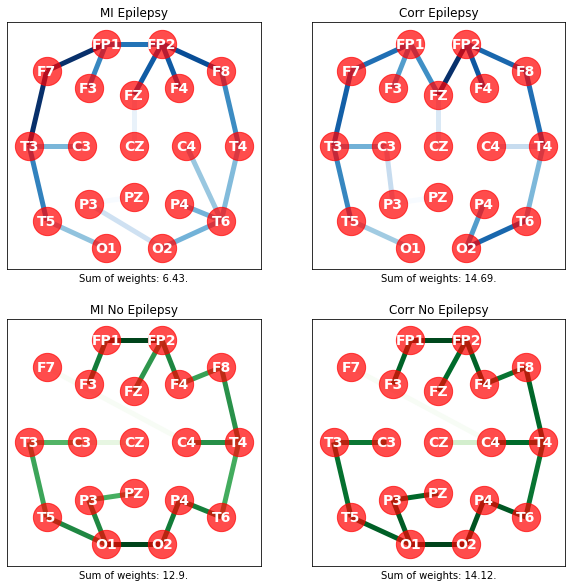

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [241]:
# xlabels = ['MI Epilepcy', 'NMI Epilepcy', 'Corr Epilepcy',
#           'MI No Epilepcy','NMI No Epilepcy', 'Corr No Epilepcy']

xlabels = ['MI Epilepsy', 'Corr Epilepsy',
           'MI No Epilepsy', 'Corr No Epilepsy']

# matrices = [mi_matrix_epilepsy, normed_mi_matrix_epilepsy, cor_matrix_epilepsy,
#            mi_matrix_no_epilepsy, normed_mi_matrix_no_epilepsy, cor_matrix_no_epilepsy]

matrices = [mi_matrix_epilepsy, cor_matrix_epilepsy,
            mi_matrix_no_epilepsy, cor_matrix_no_epilepsy]

l_edge_colors = [plt.cm.Blues, plt.cm.Blues, plt.cm.Greens, plt.cm.Greens]
node_colors = 'red'

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()

for i, fc_mat in enumerate(matrices):
  mi_df = pd.DataFrame(fc_mat.round(2), columns=channel_labels, index=channel_labels)
  # represent the adjacency matrix as an edge list
  edge_list_df = mi_df.stack().reset_index()
  edge_list_df.columns = ['from_node', 'to_node', 'weight']
  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                 (edge_list_df['from_node'] != edge_list_df['to_node'])
                                ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  T = nx.maximum_spanning_tree(G)
  edge_colors = l_edge_colors[i]
  edge_weights = plot_graph(T, ax=ax[i], add_edge_labels=False)
  #print("Minimum spanning tree with maximum weight.")
  #print(f"Sum of weights: {np.sum(list(edge_weights.values())).round(3)}. ") 
  ax[i].set_title(xlabels[i])
  ax[i].set_xlabel(f"Sum of weights: {np.sum(list(edge_weights.values())).round(3)}.")


fig.savefig('mst_graphs.pdf', dpi=150, bbox_inches='tight')

In [290]:
np.sum(list(edge_weights.values()))

12.926079965282135

# 3 - Visualize EEG data

Opening raw-browser...


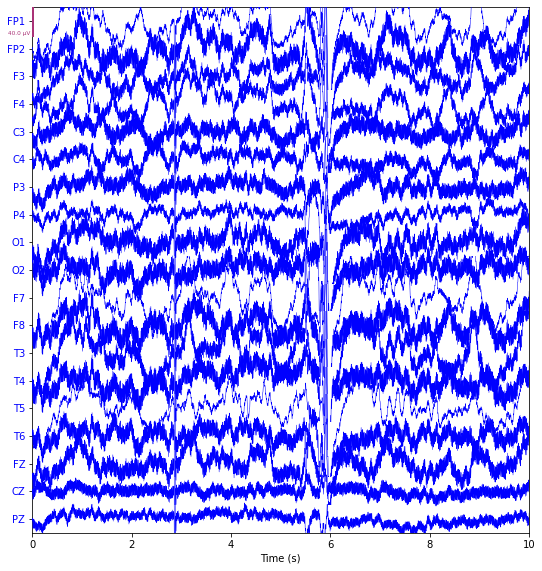

In [236]:
ch_name_update_func = lambda ch: ch.split(' ')[-1].split('-')[0]

raw_data_epilepsy = read_raw_edf(edf_file_epilepsy, verbose=False, preload=False)
raw_data_epilepsy.rename_channels(mapping=ch_name_update_func)
fig=raw_data_epilepsy.pick_channels(channels_to_use).plot(# duration=10,
                          n_channels=19, 
                          # title='No epilepsy',
                          color='blue',
                          show_scrollbars=False,
                         # show_scalebars=False
                         )
fig.savefig('raw_eeg_data_epilepsy.pdf', dpi=150, bbox_inches='tight')

Opening raw-browser...


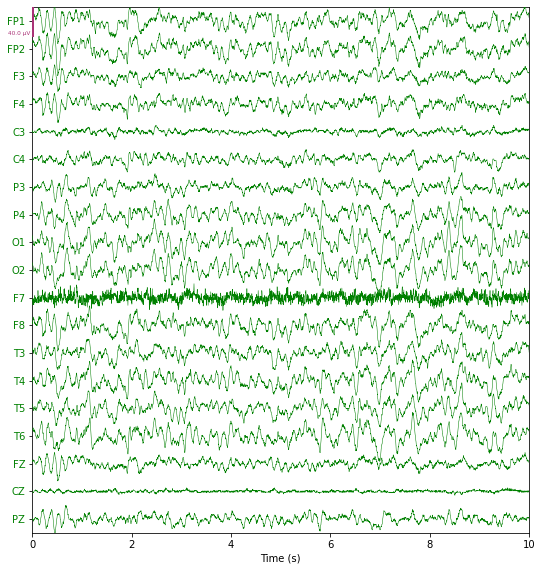

In [235]:
raw_data_no_epilepsy = read_raw_edf(edf_file_no_epilepsy, verbose=False, preload=False)
raw_data_no_epilepsy.rename_channels(mapping=ch_name_update_func)
fig = raw_data_no_epilepsy.pick_channels(channels_to_use).plot(# duration=10,
                          n_channels=19, 
                          # title='No epilepsy',
                          color='green',
                          show_scrollbars=False,
                         # show_scalebars=False
                         )
fig.savefig('raw_eeg_data_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

# 2 - Exploring EEG channels in the TUH EEG Epilepsy Corpus (TUEP)

In [182]:
# create a dataframe with overview over filenames in the TUEP
# there are 1648 files in the TUEP

df_files_overview = pd.DataFrame([f.split('/')[3:]+[f] for f in edf_file_list], 
            columns = ['text_label', 'ch_conf', '-', 'patient_id', 'session_date', 'filename', 'file_path'])

In [183]:
# create some additional columns

df_files_overview['session'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[0])
df_files_overview['year'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[1])
df_files_overview['month'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[2])
df_files_overview['numeric_label'] = df_files_overview['text_label'].replace(to_replace=['epilepsy', 'no_epilepsy'], value=[1,0])

In [184]:
df_files_overview.head(10)

,text_label,ch_conf,-,patient_id,session_date,filename,file_path,session,year,month,numeric_label
0,epilepsy,03_tcp_ar_a,076,00007656,s010_2011_03_13,00007656_s010_t000.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s010,2011,03,1
1,epilepsy,03_tcp_ar_a,076,00007656,s010_2011_03_13,00007656_s010_t001.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s010,2011,03,1
2,epilepsy,03_tcp_ar_a,076,00007656,s010_2011_03_13,00007656_s010_t003.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s010,2011,03,1
3,epilepsy,03_tcp_ar_a,076,00007656,s010_2011_03_13,00007656_s010_t002.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s010,2011,03,1
4,epilepsy,03_tcp_ar_a,076,00007656,s010_2011_03_13,00007656_s010_t005.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s010,2011,03,1
5,epilepsy,03_tcp_ar_a,076,00007656,s010_2011_03_13,00007656_s010_t004.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s010,2011,03,1
6,epilepsy,03_tcp_ar_a,076,00007656,s006_2011_03_09,00007656_s006_t004.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s006,2011,03,1
7,epilepsy,03_tcp_ar_a,076,00007656,s006_2011_03_09,00007656_s006_t000.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s006,2011,03,1
8,epilepsy,03_tcp_ar_a,076,00007656,s006_2011_03_09,00007656_s006_t001.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s006,2011,03,1
9,epilepsy,03_tcp_ar_a,076,00007656,s006_2011_03_09,00007656_s006_t003.edf,../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...,s006,2011,03,1


## 2.1 - Choosing common EEG channels for the 3 channel configurations

In [21]:
# there are 3 types of channel configurations in the TUEP

channel_configs = list(set([f.split('/')[4] for f in edf_file_list]))
print(channel_configs)

['03_tcp_ar_a', '02_tcp_le', '01_tcp_ar']


In [22]:
# get 3 files, one for each channel configuration
# to extract common channel labels

edf_files_ch_configs = [df_files_overview.query(f"ch_conf == '{ch_type}'")['file_path'].values[0] for ch_type in channel_configs]

In [23]:
edf_files_ch_configs

['../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/02_tcp_le/023/00002309/s002_2010_02_15/00002309_s002_t000.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/01_tcp_ar/104/00010412/s001_2013_03_12/00010412_s001_t000.edf']

In [37]:
# extract channel names from each configuration 
# in addition, get a short label from extracted channel name

ch_config_ch_names = {}

for filename in edf_files_ch_configs:
    raw_data = read_raw_edf(filename, verbose=False, preload=False)
    
    ch_conf = filename.split('/')[4] # ex. '03_tcp_ar_a'
    
    ch_config_ch_names[ch_conf] = raw_data.info["ch_names"] # ex. 'EEG FP1-REF'
    
    ch_config_ch_names[ch_conf+'_trim'] = [ch.split(' ')[-1].split('-')[0] for ch in raw_data.info["ch_names"]] # ex. 'FP1'

In [43]:
print('02_tcp_le_trim : \n', sorted(ch_config_ch_names['02_tcp_le_trim']))
print('01_tcp_ar_trim : \n', sorted(ch_config_ch_names['01_tcp_ar_trim']))
print('03_tcp_ar_a_trim : \n', sorted(ch_config_ch_names['03_tcp_ar_a_trim']))

02_tcp_le_trim : 
 ['26', '27', '28', '29', '30', '31', '32', 'A1', 'A2', 'C3', 'C4', 'CZ', 'DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'EKG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'OZ', 'P3', 'P4', 'PG1', 'PG2', 'PH', 'PZ', 'T3', 'T4', 'T5', 'T6']
01_tcp_ar_trim : 
 ['26', '27', '28', '29', '30', 'A1', 'A2', 'BURSTS', 'C3', 'C4', 'CZ', 'EKG1', 'EMG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'IBI', 'LOC', 'O1', 'O2', 'P3', 'P4', 'PHOTIC', 'PZ', 'ROC', 'SUPPR', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
03_tcp_ar_a_trim : 
 ['29', '30', '31', '32', 'BURSTS', 'C3', 'C3P', 'C4', 'C4P', 'CZ', 'EKG1', 'EMG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'IBI', 'O1', 'O2', 'P3', 'P4', 'PZ', 'SP1', 'SP2', 'SUPPR', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']


In [52]:
# number of channels in each configuration

for k in ch_config_ch_names.keys():
    print(f"{k}': {len(ch_config_ch_names[k])}")

03_tcp_ar_a': 34
03_tcp_ar_a_trim': 34
02_tcp_le': 41
02_tcp_le_trim': 41
01_tcp_ar': 36
01_tcp_ar_trim': 36


In [72]:
# find short channel labels that lie within each channel configuration

common_channels = (set(ch_config_electrodes['02_tcp_le_trim']).
     intersection(set(ch_config_electrodes['03_tcp_ar_a_trim'])).
     intersection(set(ch_config_electrodes['01_tcp_ar_trim']))
    )
print(sorted(list(common_channels)))

['29', '30', 'C3', 'C4', 'CZ', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6']


In [73]:
# channels '29' and '30' are not described in the
# International 10-20 system for EEG electrodes montage
# we don't know where to place them and have to we exclude them

# there are 19 channels that we find in each configuration:
print(sorted(common_channels)[2:])
print(sorted(channels_to_use))
print(f"Number of common channels: {len(channels_to_use)}")

['C3', 'C4', 'CZ', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6']
['C3', 'C4', 'CZ', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6']
Number of common channels: 19


## 2.3 - Function to Update Channel Names in EDF Files

In [125]:
# the function to update channel names from original to new format:
# 'C3', 'C4', 'CZ', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6'
ch_name_update_func = lambda ch: ch.split(' ')[-1].split('-')[0]

# renaming the original channel names in one .edf file;
# the update will be written into the in-memory edf object
raw_data_no_epilepsy.rename_channels(mapping=ch_name_update_func)

<RawEDF | 00007671_s002_t002.edf, 32 x 182000 (455.0 s), ~34 kB, data not loaded>

In [70]:
# updated channel names
print(raw_data_no_epilepsy.info["ch_names"])

['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


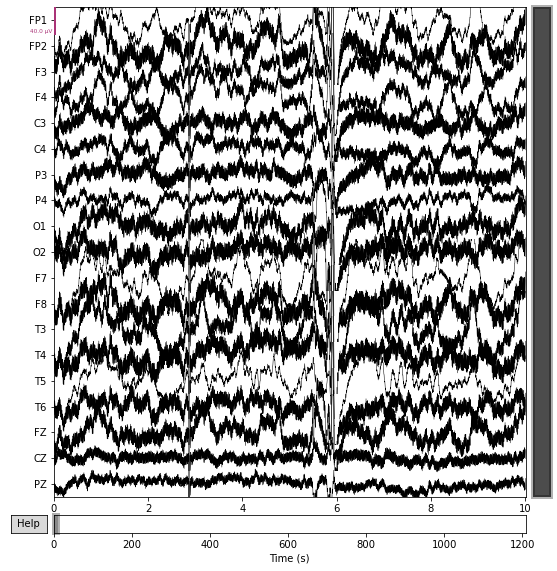

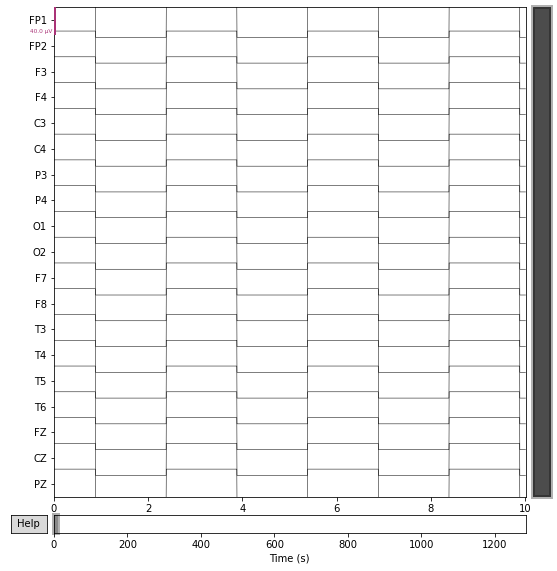

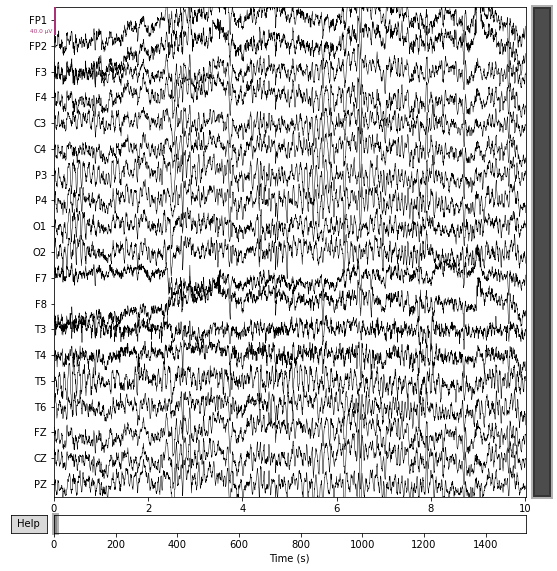

In [80]:
for filename in edf_files_ch_configs:
    raw_data = read_raw_edf(filename, verbose=False, preload=False)
    raw_data.rename_channels(mapping=ch_renaming_func)
    raw_data.pick_channels(channels_to_use).plot()

## 2.4 - Select Common Channels in EDF Files

In [86]:
# after renaming the channel names we can select the common channels
# with the '.pick_channels()' method

# we must be careful with the order of channels in the file when 
# creating a dataframe from with EEG data

# here, we read 10 values from each channel into a dataframe and give correct column names
pd.DataFrame(raw_data_no_epilepsy.pick_channels(channels_to_use).get_data().T[:10,:],
            columns=raw_data_no_epilepsy.pick_channels(channels_to_use).info['ch_names'])

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
0,0.000008,0.000008,0.000005,0.000003,-1.789561e-06,-2.689342e-06,-1.789561e-06,2.709342e-06,8.108025e-06,9.907586e-06,-0.000006,2.709342e-06,4.508903e-06,-2.689342e-06,3.609122e-06,0.000007,0.000003,-8.897806e-07,-8.897806e-07
1,0.000010,0.000009,0.000005,0.000004,1.000000e-08,-2.689342e-06,-1.789561e-06,9.097806e-07,7.208245e-06,9.007806e-06,-0.000010,9.097806e-07,5.408683e-06,-1.789561e-06,3.609122e-06,0.000008,0.000004,-8.897806e-07,-1.789561e-06
2,0.000011,0.000009,0.000005,0.000003,1.000000e-08,-1.789561e-06,-8.897806e-07,9.097806e-07,6.308464e-06,9.007806e-06,-0.000010,4.508903e-06,6.308464e-06,1.000000e-08,3.609122e-06,0.000008,0.000004,-1.789561e-06,-1.789561e-06
3,0.000012,0.000009,0.000005,0.000004,1.000000e-08,-1.789561e-06,-1.789561e-06,9.097806e-07,4.508903e-06,6.308464e-06,-0.000010,4.508903e-06,5.408683e-06,-8.897806e-07,9.097806e-07,0.000008,0.000003,-1.789561e-06,-2.689342e-06
4,0.000010,0.000010,0.000005,0.000005,-1.789561e-06,-1.789561e-06,-4.488903e-06,9.097806e-07,9.097806e-07,6.308464e-06,-0.000008,4.508903e-06,4.508903e-06,9.097806e-07,9.097806e-07,0.000008,0.000002,-1.789561e-06,-1.789561e-06
5,0.000011,0.000012,0.000005,0.000006,-1.789561e-06,-1.789561e-06,-4.488903e-06,9.097806e-07,9.097806e-07,5.408683e-06,-0.000015,8.108025e-06,4.508903e-06,1.809561e-06,1.000000e-08,0.000010,0.000002,-1.789561e-06,-1.789561e-06
6,0.000012,0.000012,0.000005,0.000008,-1.789561e-06,1.000000e-08,-3.589122e-06,9.097806e-07,9.097806e-07,4.508903e-06,-0.000013,1.080737e-05,1.809561e-06,4.508903e-06,-1.789561e-06,0.000011,0.000003,-1.789561e-06,-1.789561e-06
7,0.000012,0.000010,0.000005,0.000008,-2.689342e-06,-8.897806e-07,-4.488903e-06,9.097806e-07,1.000000e-08,4.508903e-06,-0.000009,1.080737e-05,3.609122e-06,4.508903e-06,-8.897806e-07,0.000011,0.000004,-1.789561e-06,-1.789561e-06
8,0.000012,0.000011,0.000006,0.000008,-1.789561e-06,1.000000e-08,-4.488903e-06,9.097806e-07,1.000000e-08,1.809561e-06,-0.000006,9.007806e-06,3.609122e-06,4.508903e-06,-1.789561e-06,0.000008,0.000005,-1.789561e-06,-1.789561e-06
9,0.000012,0.000011,0.000005,0.000008,-2.689342e-06,1.000000e-08,-5.388683e-06,1.000000e-08,-1.789561e-06,9.097806e-07,-0.000015,9.007806e-06,9.097806e-07,3.609122e-06,-2.689342e-06,0.000007,0.000005,-1.789561e-06,-3.589122e-06


## 2.5 - Plotting number of edges vs. threshold

In [196]:
def get_n_edges_by_thresholds(matrix, thresholds):
    """ Given a 19x19 symmetric matrix (e.g. correlation) and a list of thresholds,
        compute number of elements in the matrix that are greater than each threshold
        excluding the diagonal. These correspond to the number of edges in a FC graph.

        Return the list of  thresholds and computed numbers: thresholds_edges.
    """
    thresholds_edges = []

    for th in thresholds:
        n_ = np.sum(np.triu(np.abs(matrix)) > th)-19
        thresholds_edges.append([th, n_])
    
    return np.array(thresholds_edges)

### 2.5.1 - Plots based on NOT normalized mutual information matrices

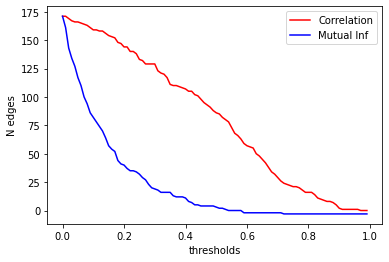

In [211]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(mi_matrix_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
plt.savefig('th_vs_edge_epilepsy.pdf', dpi=150, bbox_inches='tight')

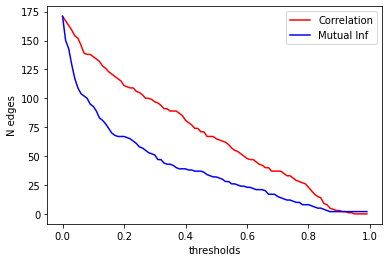

In [212]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_no_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(mi_matrix_no_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
plt.savefig('th_vs_edge_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

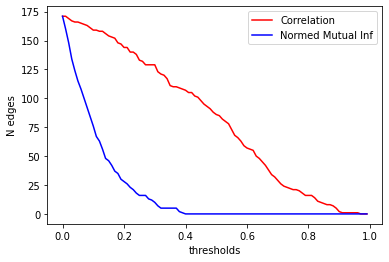

In [215]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Normed Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
plt.savefig('th_vs_edge_normed_epilepsy.pdf', dpi=150, bbox_inches='tight')

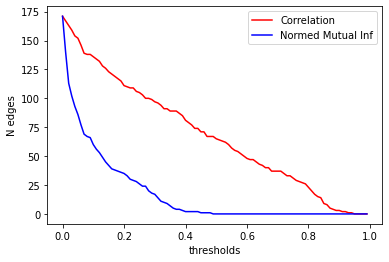

In [216]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_no_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_no_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Normed Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
plt.savefig('th_vs_edge_normed_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

# 3. Saving matrices and MST edges/weights

In [191]:
# extract subject IDs from the file path, create python set to extract unique elements from list, convert to list again 
unique_epilepsy_patient_ids = list(set([x.split("/")[-1].split("_")[0] for x in edf_file_list]))
len(unique_epilepsy_patient_ids)

200

In [192]:
edf_files_per_patient = [df_files_overview.query(f"patient_id == '{id}'")['file_path'].values[0] for id in unique_epilepsy_patient_ids]

In [206]:
# Compute number of bins using Sturge's rule

def compute_mi_matrix(bins, df):
    """ Compute normalized Mutual Information matrix.
    
        Return: normed_mi_matrix
    """
    n_cols = df.shape[1]
    mi_matrix = np.zeros([n_cols, n_cols])
    
    # Sturge's rule for number of bins
    n_bins = int(1 + 3.322*np.log2(df.shape[0]))
    
    for i in range(n_cols):
        for j in range(n_cols):
            mi = mutual_information(n_bins, df.iloc[:,i],df.iloc[:,j])
            mi_matrix[i,j] = mi
    
    # normalize mi matrix by dividing matrix elements with
    # sqrt of product of respective diagonal elements
    # divisor_matrix = np.sqrt(np.diag(mi_matrix)*np.diag(mi_matrix).reshape(-1,1))
    # normed_mi_matrix = mi_matrix/divisor_matrix
    
    return mi_matrix
    #return normed_mi_matrix

In [228]:
chosen_files=[f for f in edf_files_per_patient if '/epilepsy/' in f][:20] + [f for f in edf_files_per_patient if 'no_epilepsy' in f][:20]

In [213]:
# store normed MI matrices into a dictionary with edf filename as a key

dict_edf_file_mi_matrix = {}

for i, edf_file in enumerate(chosen_files):
    df, ch = read_edf_to_pandas(edf_file)
    normed_mi_matrix = compute_mi_matrix(bins=0, df=df)
    dict_edf_file_mi_matrix[edf_file] = normed_mi_matrix
    if i%5==0:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [214]:
# save the obtained dictionary into a file using joblib

import joblib

joblib.dump(dict_edf_file_mi_matrix, 'mi_matrices.data')

['mi_matrices.data']

In [215]:
# loading the dictionary with MI matrices from a file

dict_edf_file_mi_matrix = joblib.load('mi_matrices.data')

## 3.1 - Saving MST data

In [216]:
def plot_graph(G, add_edge_labels=False):
    plt.figure(figsize=(8,8))

    # plot nodes
    nx.draw_networkx_nodes(G,
                           node_positions,
                           nodelist=nodelist,
                           node_size=1000, 
                           node_color='red',
                           alpha=0.7)

    # plot node labels
    nx.draw_networkx_labels(G,
                            node_positions,
                            labels=dict(zip(nodelist, nodelist)),
                            font_color='white',
                            font_size=14,
                            font_weight='bold'
                           )
    
    edge_weights = nx.get_edge_attributes(G,'weight')
    
    # plot edges
    plt_graph_obj = nx.draw_networkx_edges(
        G, node_positions,
        edge_cmap=plt.cm.Blues,
        width=5,
        edge_color=[G[u][v]['weight'] for u, v in G.edges]
    )
    
    # plot edge labels (weights)
    if add_edge_labels:
        edge_labels = nx.draw_networkx_edge_labels(
            G, node_positions,
            edge_labels=edge_weights,
            label_pos=0.5
        )
    
    plt.box(False)
    
    return edge_weights

In [217]:
dict_mst_tree = {}

for edf_file in chosen_files:
    # make a dataframe from a matrix 
    # this will be our adjacency matrix
    channel_labels = ['FP1', 'FP2', 
                      'F7', 'F3', 'FZ', 'F4', 'F8',
                      'T3', 'C3', 'CZ', 'C4', 'T4',
                      'T5', 'P3', 'PZ', 'P4', 'T6',
                      'O1', 'O2']
    normed_mi_matrix = dict_edf_file_mi_matrix[edf_file]

    mi_df = pd.DataFrame(normed_mi_matrix.round(3), 
                      columns=channel_labels)

    mi_df.index = channel_labels

    # represent the adjacency matrix as an edge list
    edge_list_df = mi_df.stack().reset_index()
    edge_list_df.columns = ['from_node', 'to_node', 'weight']

    # exclude 0-weight edges and self-edges 
    graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                   (edge_list_df['from_node'] != edge_list_df['to_node'])
                                     ]
    # create the graph
    G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')

    # get max spanning tree
    T = nx.maximum_spanning_tree(G)
    edge_weights = nx.get_edge_attributes(T,'weight')
    
    dict_mst_tree[edf_file] = T

In [218]:
# create a dataframe with overview over filenames in the TUEP
# there are 1648 files in the TUEP

df_files_overview = pd.DataFrame([f.split('/')[3:]+[f] for f in edf_file_list], 
            columns = ['text_label', 'ch_conf', '-', 'patient_id', 'session_date', 'filename', 'file_path'])

In [219]:
# create some additional columns

df_files_overview['session'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[0])
df_files_overview['year'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[1])
df_files_overview['month'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[2])
df_files_overview['numeric_label'] = df_files_overview['text_label'].replace(to_replace=['epilepsy', 'no_epilepsy'], value=[1,0])

In [220]:
# df_mst_weight_sums = pd.DataFrame(columns=['edf_file', 'text_label', 'weight_sum'])

for i, edf_file in enumerate(chosen_files):
    T = dict_mst_tree[edf_file]
    edge_weights = nx.get_edge_attributes(T,'weight')

  #  df_mst_edges_weights = (pd.DataFrame(edge_weights.values(),
  #                                      index=edge_weights.keys(),
  #                                      columns=['weight']).
  #                          reset_index().
  #                          rename(columns={'level_0':'from_node', 'level_1':'to_node'})
  #                         )

    # df_mst_weight_sums.loc[i,'edf_file'] = edf_file
    # df_mst_weight_sums.loc[i,'weight_sum'] = np.sum(list(edge_weights.values()))
    df_files_overview.loc[df_files_overview['file_path']==edf_file, 'mst_sum'] = np.sum(list(edge_weights.values()))

text_label
epilepsy       AxesSubplot(0.125,0.125;0.775x0.755)
no_epilepsy    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mst_sum, dtype: object

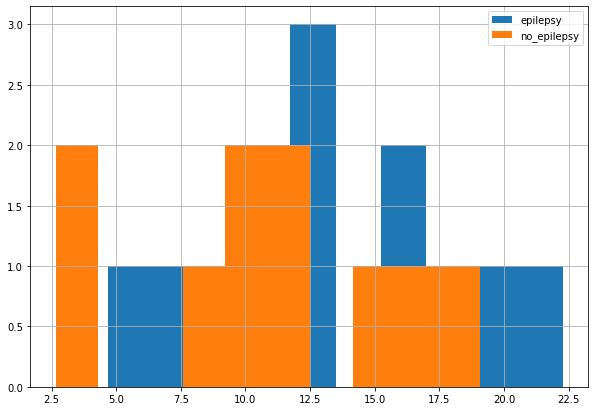

In [224]:
df_files_overview.query('mst_sum>0').groupby('text_label')['mst_sum'].hist(legend=True, figsize=(10,7))

In [226]:
df_files_overview.query('mst_sum>0').groupby('text_label')['mst_sum'].agg(['mean', 'median', 'std'])

,mean,median,std
text_label,,,
epilepsy,13.5664,13.3685,5.483915
no_epilepsy,10.8499,10.9335,5.417163


In [237]:
from scipy import stats
stats.ttest_ind(df_files_overview.query('(mst_sum>0) and (numeric_label==1)')['mst_sum'].values,
                df_files_overview.query('(mst_sum>0) and (numeric_label==0)')['mst_sum'].values)

Ttest_indResult(statistic=1.114415490726023, pvalue=0.2797604134837688)

In [148]:
joblib.dump(dict_mst_tree, 'mi_mst_trees.data')

['mi_mst_trees.data']

In [149]:
dict_mst_tree = joblib.load('mi_mst_trees.data')

In [ ]:
dict_mst_tree.keys()

In [205]:
for m in dict_edf_file_mi_matrix.values():
    if (m < 0).any():
        print(m)